In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight


# Import Data


In [2]:
training_data = pd.read_csv("PastLoans.csv")

In [3]:
training_data = training_data.drop(["digital1", "digital2"], axis=1)
training_data.head()

,sex,employment,married,income,digital3,default
0,M,unemployed,0,0,0.738735,0
1,M,employed,1,26108,0.733947,0
2,M,employed,1,11810,0.000000,0
3,M,unemployed,1,0,0.000000,0
4,F,retired,1,6310,0.203202,0


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sex         100000 non-null  object 
 1   employment  100000 non-null  object 
 2   married     100000 non-null  int64  
 3   income      100000 non-null  int64  
 4   digital3    100000 non-null  float64
 5   default     100000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


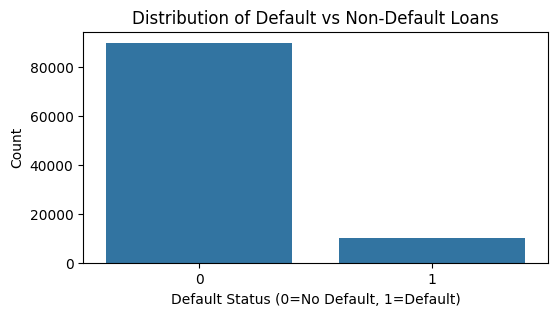

In [5]:
plt.figure(figsize=(6, 3))
sns.countplot(data=training_data, x='default')
plt.title('Distribution of Default vs Non-Default Loans')
plt.xlabel('Default Status (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.show()

# Heavely unbalanced dataset

In [6]:
training_data.employment.unique()

array(['unemployed', 'employed', 'retired', 'student'], dtype=object)

In [7]:
# Convert sex to numeric (M=0, F=1)
training_data['sex'] = (training_data['sex'] == 'F').astype(int)

# Convert employment to numeric
employment_mapping = {
    'unemployed': 0,
    'employed': 1,
    'retired': 2,
    'student': 3
}
training_data['employment'] = training_data['employment'].map(employment_mapping)

X = training_data.drop(["default"], axis=1)
y = training_data["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


use class weights to deal with unbalanced dataset

In [8]:
# Calculate class weights (will give more importance to defaults)

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(training_data['default']),
                                   y=training_data['default'])
class_weight_dict = dict(zip(np.unique(training_data['default']), class_weights))



# For XGBoost
xgb_model = XGBClassifier(scale_pos_weight=class_weights[1]/class_weights[0])

# For Logistic Regression
lr_model = LogisticRegression(class_weight=class_weight_dict)

# For Neural Network
class_weight_dict_float = {k: float(v) for k, v in class_weight_dict.items()}
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train and evaluate models

# Convert data to numpy arrays for the neural network
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()


# Train models
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
nn_model.fit(X_train_np, y_train_np, epochs=10, class_weight=class_weight_dict_float, verbose=0)

# Get predictions
models = {
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model, 
    'Neural Network': nn_model
}

metrics = {
    'Recall': [],
    'Precision': [],
    'F1 Score': []
}

for name, model in models.items():
    if name == 'Neural Network':
        y_pred = model.predict(X_test_np)
        y_pred = (y_pred > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


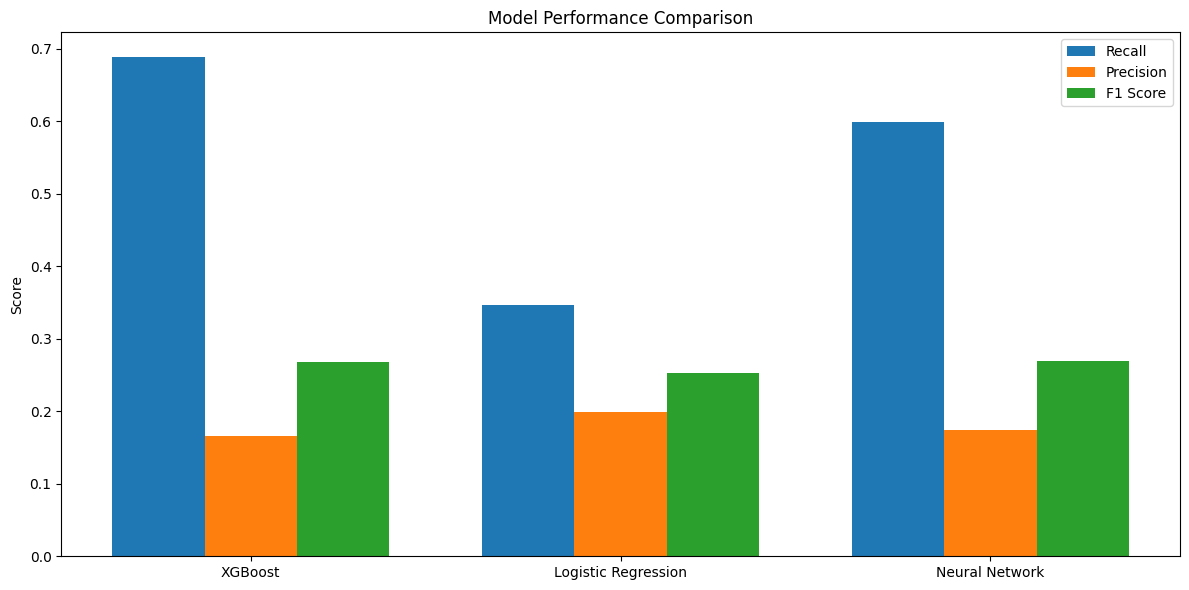

In [10]:
# Plot results
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, metrics['Recall'], width, label='Recall')
ax.bar(x, metrics['Precision'], width, label='Precision')
ax.bar(x + width, metrics['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend()

plt.tight_layout()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


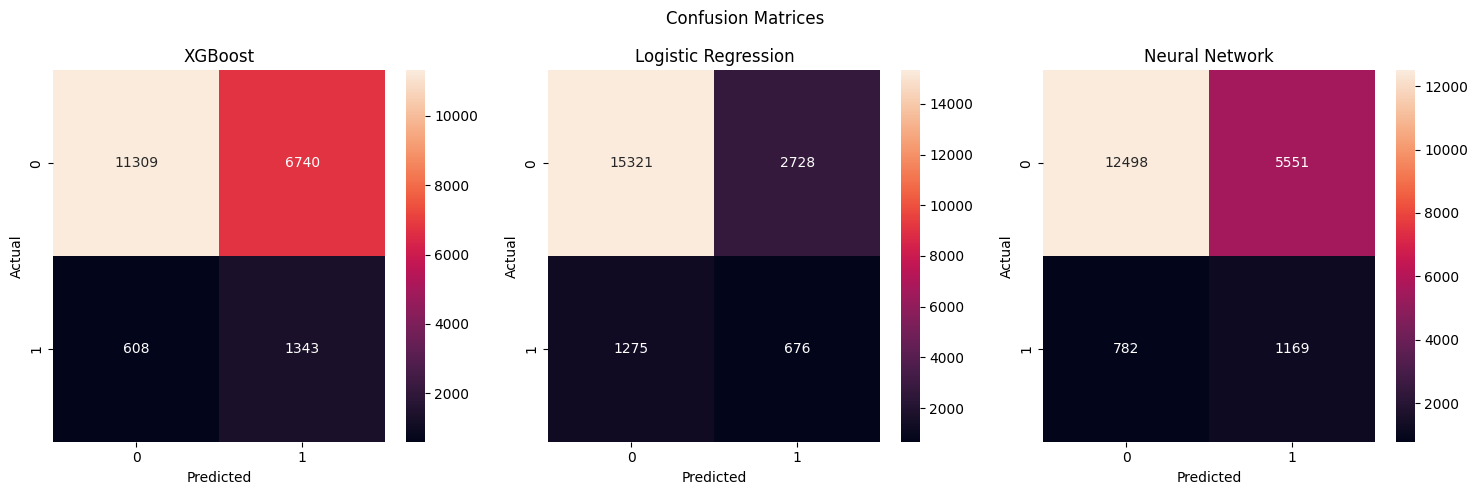

In [11]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices')

for i, (name, model) in enumerate(models.items()):
    if name == 'Neural Network':
        y_pred = model.predict(X_test_np)
        y_pred = (y_pred > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


To minimize the P&L, we want to minimize the number of predicted non-defaults that are actually defaults (i.e. the bottom left corner of confusion matrix). XGBoost seems to be the best for this but it is also predicting a lot of defaults that are not defaults. This means lower profit but may be a sacrifice we need to make to minimize the losses.

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step


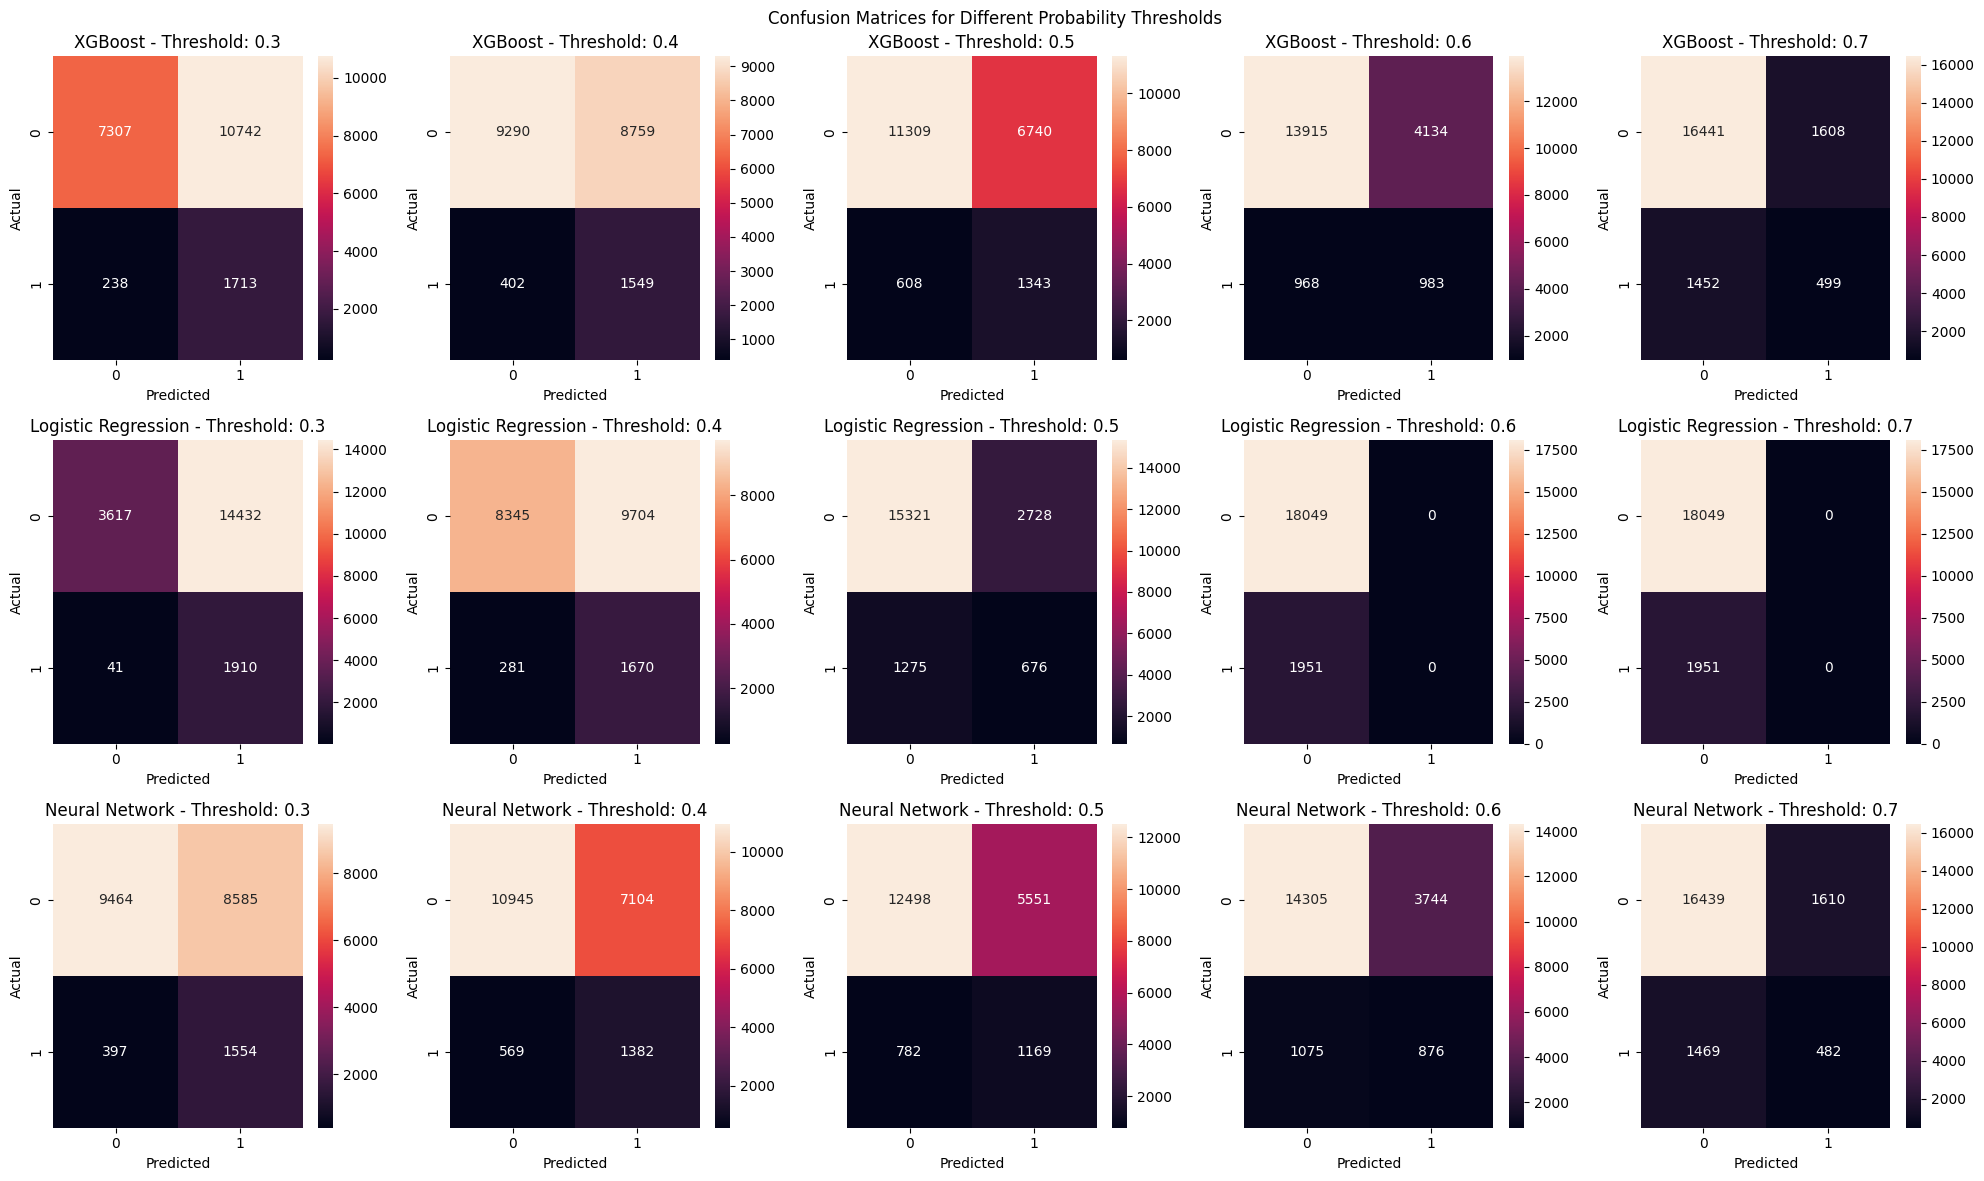

In [22]:
# Test different probability thresholds for classification
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7] # Reduced to 3 thresholds for clearer comparison
fig, axes = plt.subplots(len(models), len(thresholds), figsize=(20, 12))
fig.suptitle('Confusion Matrices for Different Probability Thresholds')

# Get probabilities instead of predictions for each model
for row, (name, model) in enumerate(models.items()):
    if name == 'Neural Network':
        y_pred_proba = model.predict(X_test_np)
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    for col, threshold in enumerate(thresholds):
        # Convert probabilities to predictions based on threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[row, col])
        axes[row, col].set_title(f'{name} - Threshold: {threshold}')
        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')

plt.tight_layout()
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step

Profit & Loss Analysis:
                  Model  Threshold         Total P&L Average P&L per loan
0               XGBoost        0.3   10411467.980917           520.573399
1               XGBoost        0.4   19949110.132368           997.455507
2               XGBoost        0.5   35042517.917116          1752.125896
3               XGBoost        0.6   64330581.785353          3216.529089
4               XGBoost        0.7  107218798.626765          5360.939931
5   Logistic Regression        0.3    8370192.508156           418.509625
6   Logistic Regression        0.4   33735697.959082          1686.784898
7   Logistic Regression        0.5   78580484.594392           3929.02423
8   Logistic Regression        0.6   99646085.706742          4982.304285
9   Logistic Regression        0.7   99646085.706742          4982.304285
10       Neural Network        0.3       [7212045.0]          [360.60226]
11       Neural Network        0.4      [137

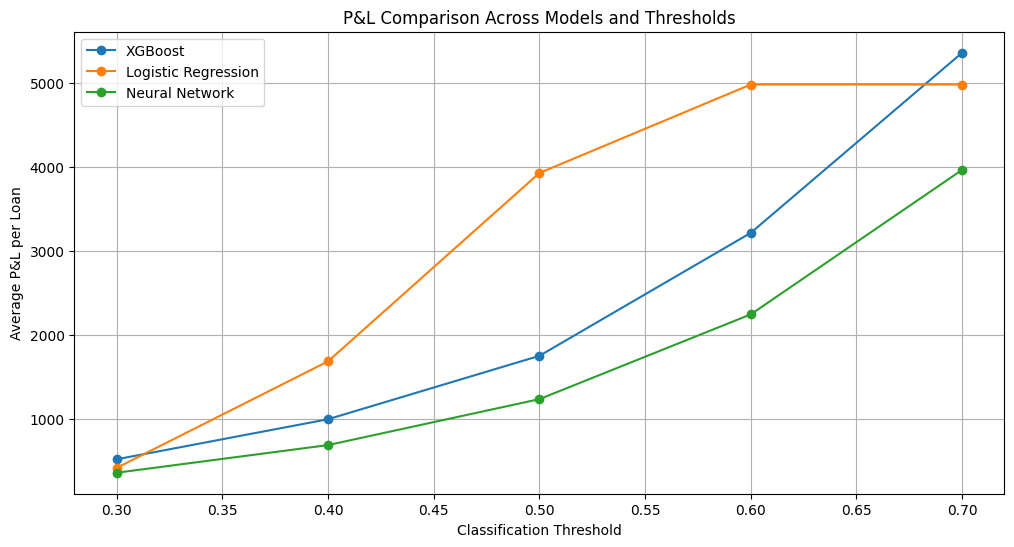

In [13]:
# Define loan parameters
LOAN_AMOUNT = 10000  # Fixed loan amount for each customer
COMMISSION_RATE = 0.02 # 2% commission on top of break even rate 

def calculate_break_even_rate(prob_of_default):
    return prob_of_default / (1 - prob_of_default)

# Function to calculate P&L
def calculate_pnl(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    break_even_rate = calculate_break_even_rate(y_pred_proba)
    
    profit_loss = 0
    for actual, predicted, be_rate in zip(y_true, y_pred, break_even_rate):
        if predicted == 0:  # If we decide to give the loan
            interest_rate = be_rate + COMMISSION_RATE  # Total interest rate charged
            if actual == 0:  # Non-default case: We earn full interest
                profit_loss += LOAN_AMOUNT * interest_rate
            else:  # Default case: We lose the loan amount
                profit_loss -= LOAN_AMOUNT

    return profit_loss

# Calculate and compare P&L for different models and thresholds
results = []
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for name, model in models.items():
    if name == 'Neural Network':
        y_pred_proba = model.predict(X_test_np)
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    for threshold in thresholds:
        pnl = calculate_pnl(y_test, y_pred_proba, threshold)
        results.append({
            'Model': name,
            'Threshold': threshold,
            'Total P&L': pnl,
            'Average P&L per loan': pnl / len(y_test)
        })

# Create DataFrame and display results
results_df = pd.DataFrame(results)
print("\nProfit & Loss Analysis:")
print(results_df)

# Plot results
plt.figure(figsize=(12, 6))
for name in models.keys():
    model_results = results_df[results_df['Model'] == name]
    plt.plot(model_results['Threshold'], model_results['Average P&L per loan'], marker='o', label=name)

plt.xlabel('Classification Threshold')
plt.ylabel('Average P&L per Loan')
plt.title('P&L Comparison Across Models and Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# Using SMOTE to deal with unbalanced dataset
SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method that creates synthetic examples of the minority class.

In [14]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Combination of SMOTE and ENN
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# For Random Forest
rf_model = RandomForestClassifier(
    class_weight='balanced',  # or class_weight={0:1, 1:10}
    random_state=42
)

# For Gradient Boosting
gb_model = GradientBoostingClassifier(
    random_state=42,
    # Use subsample to give more weight to minority class
    subsample=0.8,
    # Can adjust these parameters to handle imbalanced data
    n_estimators=100,
    learning_rate=0.1
)

In [16]:
# For Neural Networks with Keras
def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weights = y_true * one_weight + (1 - y_true) * zero_weight
        return K.mean(b_ce * weights)
    return loss

model.compile(
    loss=weighted_binary_crossentropy(0.1, 0.9),
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Balanced Random Forest
brf = BalancedRandomForestClassifier(random_state=42)

# Easy Ensemble (uses AdaBoost with balanced bagging)
eec = EasyEnsembleClassifier(random_state=42)

In [18]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_recall_curve, average_precision_score

# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# F1 score with different averaging
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step


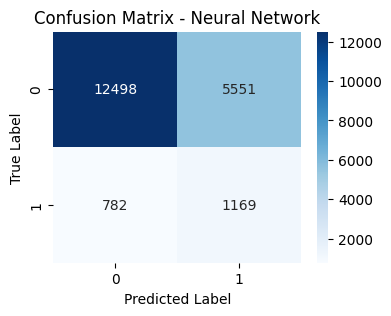

/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


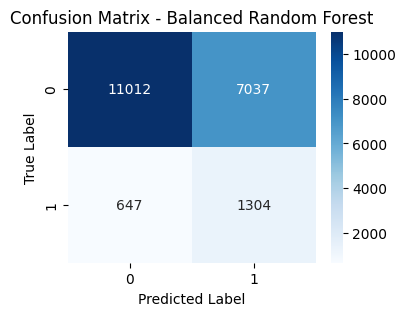

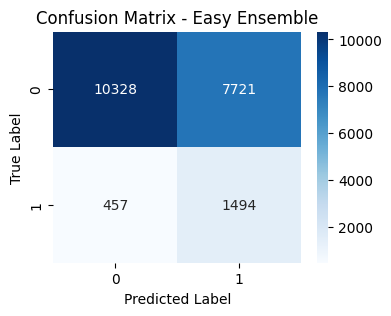

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Neural Network confusion matrix
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = (y_pred_nn > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_nn_classes, 'Neural Network')

# Balanced Random Forest confusion matrix 
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
plot_confusion_matrix(y_test, y_pred_brf, 'Balanced Random Forest')

# Easy Ensemble confusion matrix
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)
plot_confusion_matrix(y_test, y_pred_eec, 'Easy Ensemble')


# Predict on new data

In [80]:
prediction_data = pd.read_csv("NewApplications_Lender3_Round2.csv")
prediction_data.info()
prediction_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   sex         100000 non-null  object 
 2   employment  100000 non-null  object 
 3   married     100000 non-null  int64  
 4   income      100000 non-null  int64  
 5   digital3    100000 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


,id,sex,employment,married,income,digital3
0,100001,M,employed,1,8139,0.000000
1,100002,M,employed,1,12794,0.000000
2,100003,M,employed,1,15755,0.000000
3,100004,F,employed,1,768163,0.116270
4,100005,M,employed,1,27633,0.085842


In [81]:
prediction_data.employment.unique()

array(['employed', 'student', 'unemployed', 'retired'], dtype=object)

In [ ]:
prediction_data['sex'] = (prediction_data['sex'] == 'F').astype(int)

# Convert employment to numeric
employment_mapping = {
    'unemployed': 0,
    'employed': 1,
    'retired': 2,
    'student': 3
}

prediction_data['employment'] = prediction_data['employment'].map(employment_mapping)

prediction_data.head()

# Grid search to find best parameters

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scale_pos_weight': [class_weights[1]/class_weights[0], (class_weights[1]/class_weights[0])*0.8, (class_weights[1]/class_weights[0])*1.2],
    'max_depth': [8],
    'learning_rate': [0.005, 0.01, 0.015],
    'n_estimators': [200],
    'min_child_weight': [2],
    'gamma': [0, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [1.0]
}

xgb_model = XGBClassifier()
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Now we can access the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model for predictions
best_model = grid_search.best_estimator_


Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.005, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': 7.242625917362019, 'subsample': 0.8}
Best score: 0.2952403020914806


In [ ]:
# Make predictions with best model
y_pred = best_model.predict(X_test)

# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions using 0.3 threshold
y_pred = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with 0.5 threshold, maximising F1 score')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [90]:
# Create parameter grid for accuracy-focused model without class weights
param_grid_accuracy = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200],
    'min_child_weight': [1, 2, 4],
    'gamma': [0, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [1.0]
}

# Create new XGBoost model without class weights
xgb_model_accuracy = XGBClassifier()

# Set up GridSearchCV optimizing for accuracy
grid_search_accuracy = GridSearchCV(
    estimator=xgb_model_accuracy,
    param_grid=param_grid_accuracy,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search_accuracy.fit(X_train, y_train)

# Print results
print("\nAccuracy-focused model results:")
print("Best parameters:", grid_search_accuracy.best_params_)
print("Best score:", grid_search_accuracy.best_score_)

# Store the best accuracy-focused model
best_model_accuracy = grid_search_accuracy.best_estimator_




Accuracy-focused model results:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: 0.90005


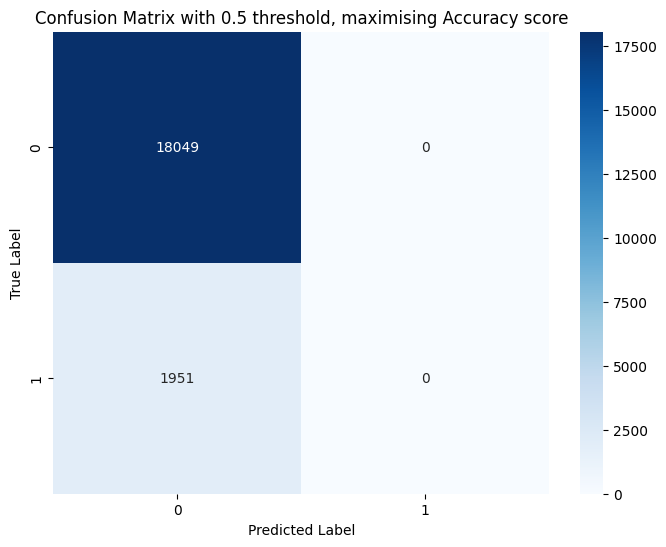

In [91]:
# Make predictions with best model
y_pred = best_model_accuracy.predict(X_test)


# Get predictions using 0.3 threshold
y_pred = (best_model_accuracy.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with 0.5 threshold, maximising Accuracy score')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [97]:
X_prediction = prediction_data.drop(["id"], axis=1)

# Make predictions on prediction data
predictions = best_model.predict(X_prediction)
default_probability_F1_model = best_model.predict_proba(X_prediction)[:, 1]

default_probability_accuracy_model = best_model_accuracy.predict_proba(X_prediction)[:, 1]


# Initialize interest rates array
interest_rate = np.zeros(len(predictions))




# Create mask for F1 model high risk predictions (>= 0.5)
mask_f1_high_risk = default_probability_F1_model >= 0.5
# Set default probability to 1 (which will result in 0 interest rate) where F1 model predicts default
default_probability_accuracy_model[mask_f1_high_risk] = 1.0


# Calculate base interest rates where applicable
# Define risk thresholds with more granular ranges
mask_very_low_risk = default_probability_accuracy_model < 0.05
mask_low_risk = (default_probability_accuracy_model >= 0.05) & (default_probability_accuracy_model < 0.1)
mask_low_med_risk = (default_probability_accuracy_model >= 0.1) & (default_probability_accuracy_model < 0.2)
mask_high_med_risk = (default_probability_accuracy_model >= 0.2) & (default_probability_accuracy_model < 0.5)

# Apply progressively increasing interest rate markups based on risk level
interest_rate[mask_very_low_risk] = calculate_break_even_rate(default_probability_accuracy_model[mask_very_low_risk]) + 0.01  # +1%
interest_rate[mask_low_risk] = calculate_break_even_rate(default_probability_accuracy_model[mask_low_risk]) + 0.03  # +3%
interest_rate[mask_low_med_risk] = calculate_break_even_rate(default_probability_accuracy_model[mask_low_med_risk]) + 0.06  # +6%
interest_rate[mask_high_med_risk] = calculate_break_even_rate(default_probability_accuracy_model[mask_high_med_risk]) + 0.10  # +10%
# High risk (>= 0.5) remains at 0


# Set interest rate to NaN where it's currently 0 (high risk)
interest_rate[interest_rate == 0] = np.nan

# Cap interest rate at 100%
interest_rate = np.minimum(interest_rate, 1.0)

# Create output dataframe with ID and predictions
output_df = pd.DataFrame({
    'id': prediction_data['id'],
    'interest_rate': interest_rate 
})

# Save to CSV
output_df.to_csv('predicted_interest_rates.csv', index=False)

# Display first few rows
print("\nFirst few rows of predictions:")
print(output_df.head())


First few rows of predictions:
       id  interest_rate
0  100001       0.207978
1  100002       0.129824
2  100003       0.114137
3  100004       0.046505
4  100005       0.086225


In [98]:
default_probability_accuracy_model[default_probability_accuracy_model < 1].mean()

0.08010014

In [99]:
output_df.describe()

,id,interest_rate
count,100000.000000,73916.000000
mean,150000.500000,0.123272
std,28867.657797,0.059681
min,100001.000000,0.040159
25%,125000.750000,0.082780
50%,150000.500000,0.110806
75%,175000.250000,0.182280
max,200000.000000,0.425865


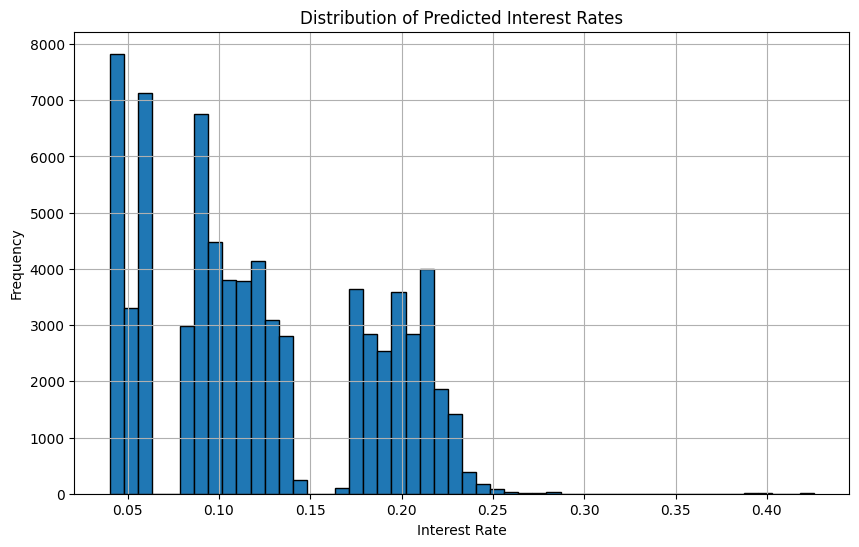

In [100]:
plt.figure(figsize=(10, 6))
plt.hist(output_df.interest_rate, bins=50, edgecolor='black')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Interest Rates')
plt.grid(True)
plt.show()

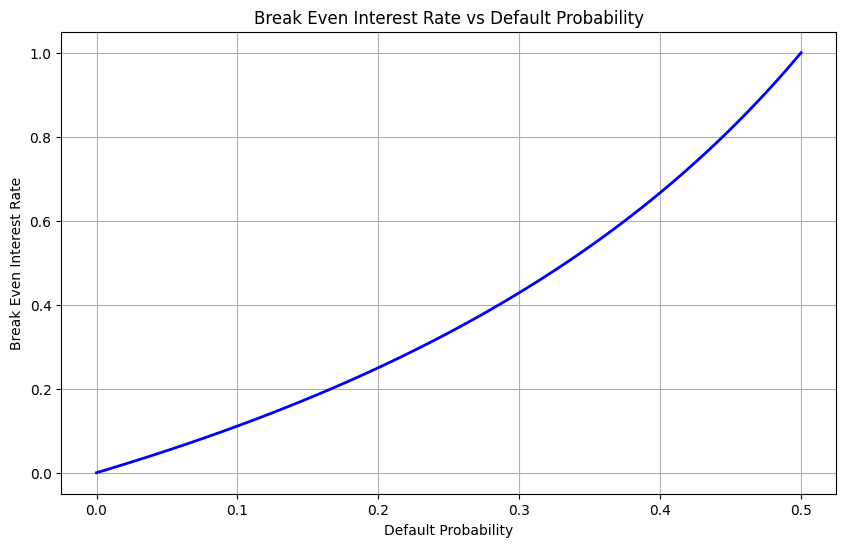

In [76]:
# Create a range of default probabilities from 0 to 1
default_probs_range = np.linspace(0, 0.5, 100)

# Calculate break even rates for each probability
break_even_rates = calculate_break_even_rate(default_probs_range)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(default_probs_range, break_even_rates, 'b-', linewidth=2)
plt.xlabel('Default Probability')
plt.ylabel('Break Even Interest Rate')
plt.title('Break Even Interest Rate vs Default Probability')
plt.grid(True)
plt.show()


In [63]:
past_loans = pd.read_csv("Round1_Diagnostic_32.csv")
past_loans.head()


,id,own,competing1,competing2,borrowertype,accepted,default,profit
0,1,0.013320,0.027688,0.042200,3,1,0,133.19841
1,2,0.150047,0.967304,0.206900,1,1,1,-10000.00000
2,3,0.178069,0.028157,0.031022,3,0,0,NaN
3,4,0.132574,0.827000,0.099100,3,0,0,NaN
4,5,0.284470,1.000000,0.368400,1,1,0,2844.69750


In [86]:
past_loans.own.mean()

0.12155215199277529